<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/%EB%AF%B8%E1%84%89%E1%85%A7%E1%86%AB9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 및 DataLoader 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위로 정규화
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.81MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 154kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
import torch
import torch.nn as nn

image_size = 28      # Fashion MNIST 이미지 크기
num_classes = 10     # 10개 클래스
latent_dim = 100     # 잠재 공간 차원

# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

batch_size = 16
noise = torch.randn(batch_size, latent_dim)
labels = torch.randint(0, num_classes, (batch_size, ))

generator = Generator()
discriminator = Discriminator()

fake_imgs = generator(noise, labels)
print("Fake images shape:", fake_imgs.shape)        # (16, 1, 28, 28)

validity = discriminator(fake_imgs, labels)
print("Validity shape:", validity.shape)            # (16, 1)


Fake images shape: torch.Size([16, 1, 28, 28])
Validity shape: torch.Size([16, 1])


In [ ]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 30
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [1/30]  D_loss: 0.8000  G_loss: 1.2424
Epoch [2/30]  D_loss: 1.4192  G_loss: 1.2824
Epoch [3/30]  D_loss: 0.9369  G_loss: 2.0899
Epoch [4/30]  D_loss: 0.9728  G_loss: 1.8096
Epoch [5/30]  D_loss: 1.1853  G_loss: 2.1587
Epoch [6/30]  D_loss: 1.0313  G_loss: 0.8541
Epoch [7/30]  D_loss: 1.2170  G_loss: 0.8835
Epoch [8/30]  D_loss: 1.0645  G_loss: 1.7161
Epoch [9/30]  D_loss: 0.7643  G_loss: 1.5379
Epoch [10/30]  D_loss: 0.9597  G_loss: 1.7163


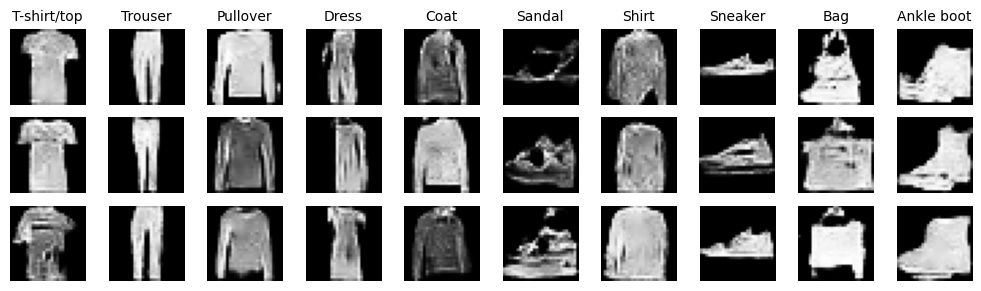

Epoch [11/30]  D_loss: 1.0550  G_loss: 0.7632
Epoch [12/30]  D_loss: 0.8589  G_loss: 0.9040
Epoch [13/30]  D_loss: 0.8982  G_loss: 1.3762
Epoch [14/30]  D_loss: 0.8485  G_loss: 1.5930
Epoch [15/30]  D_loss: 1.2115  G_loss: 1.2938
Epoch [16/30]  D_loss: 1.1384  G_loss: 2.0283
Epoch [17/30]  D_loss: 0.8287  G_loss: 1.3460
Epoch [18/30]  D_loss: 0.8053  G_loss: 1.9453
Epoch [19/30]  D_loss: 0.8280  G_loss: 1.2293
Epoch [20/30]  D_loss: 0.8871  G_loss: 1.4063


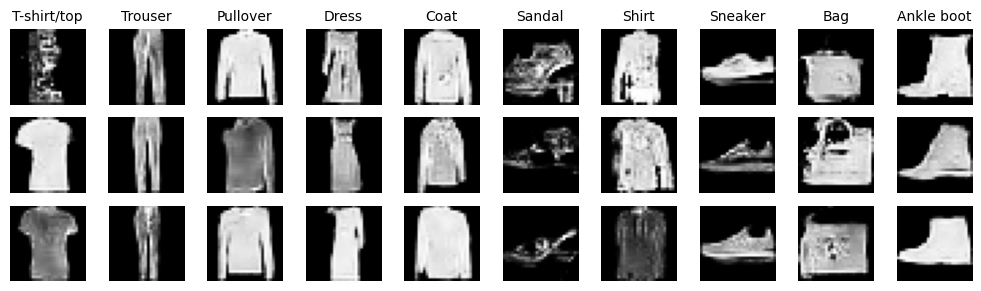

Epoch [21/30]  D_loss: 1.0856  G_loss: 0.9247
Epoch [22/30]  D_loss: 1.0008  G_loss: 1.0072
Epoch [23/30]  D_loss: 0.7321  G_loss: 1.9016
Epoch [24/30]  D_loss: 0.7454  G_loss: 2.0386
Epoch [25/30]  D_loss: 0.5946  G_loss: 1.6874
Epoch [26/30]  D_loss: 0.8944  G_loss: 2.3228
Epoch [27/30]  D_loss: 1.1330  G_loss: 2.3888
Epoch [28/30]  D_loss: 0.7899  G_loss: 1.6159
Epoch [29/30]  D_loss: 0.7527  G_loss: 1.6638
Epoch [30/30]  D_loss: 1.1795  G_loss: 0.9874


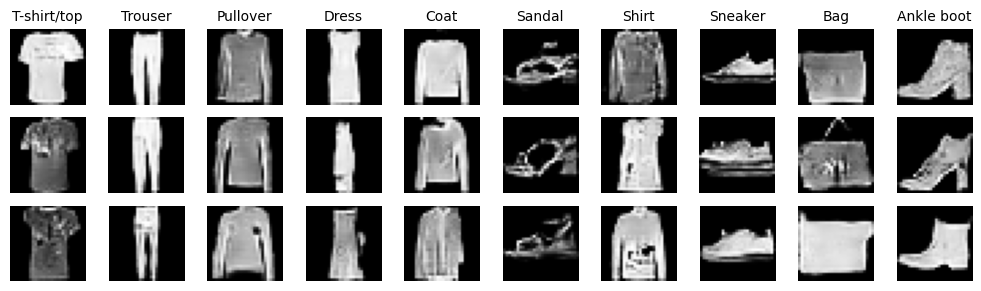

In [ ]:
# 학습 루프
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs, labels), valid)

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels
        gen_imgs = generator(noise, gen_labels)
        fake_loss = criterion(discriminator(gen_imgs.detach(), labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        generator.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples = n_row * n_col
        noise = torch.randn(total_samples, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        gen_imgs = generator(noise, labels_sample).detach().cpu()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                if i == 0:
                    axs[i, j].set_title(idx_to_class[j], fontsize=10)
        plt.tight_layout()
        plt.show()
        generator.train()

1. D_loss (Discriminator 손실)
- 낮으면 → 판별자가 잘 맞히고 있다는 뜻.
- 높으면 → 판별자가 헷갈리고 있다는 뜻.

2. G_loss (Generator 손실)
- 낮으면 → 생성자가 판별자를 잘 속이고 있다는 뜻.
- 높으면 → 생성자가 아직 진짜처럼 못 그리고 있다는 뜻.

# 모델

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils as utils

image_size = 28      # Fashion MNIST 이미지 크기
num_classes = 10     # 10개 클래스(10개의 패션 아이템)
latent_dim = 100     # 잠재 공간 차원, 노이즈 벡터 길이

# Residual Block 정의
# 생성자용 Residual Block (BatchNorm + ReLU 포함)
class GenResidualBlock(nn.Module):
    def __init__(self, channels):
        super(GenResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # 입력에 변화량 더하기 (skip connection)

# 개선된 Generator
class ResNetGenerator(nn.Module):
    def __init__(self):
        super(ResNetGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            GenResidualBlock(128),           # Residual Block 추가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 → 28
            GenResidualBlock(64),            # Residual Block 추가
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 판별자용 Residual Block (Spectral Norm + LeakyReLU 포함)
class DiscResidualBlock(nn.Module):
    def __init__(self, channels):
        super(DiscResidualBlock, self).__init__()
        self.block = nn.Sequential(
            utils.spectral_norm(nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            utils.spectral_norm(nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)),
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# 개선된 Discriminator
class ResNetDiscriminator(nn.Module):
    def __init__(self):
        super(ResNetDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            DiscResidualBlock(64),            # Residual Block 추가
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            DiscResidualBlock(128),           # Residual Block 추가
            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

# 학습

Epoch [1/30]  D_loss: 1.1349  G_loss: 1.1241  LR_G: 0.000200  LR_D: 0.000200
Epoch [2/30]  D_loss: 1.0372  G_loss: 1.7451  LR_G: 0.000200  LR_D: 0.000200
Epoch [3/30]  D_loss: 1.0115  G_loss: 1.4210  LR_G: 0.000200  LR_D: 0.000200
Epoch [4/30]  D_loss: 1.1062  G_loss: 1.8720  LR_G: 0.000200  LR_D: 0.000200
Epoch [5/30]  D_loss: 1.2175  G_loss: 1.2233  LR_G: 0.000200  LR_D: 0.000200
Epoch [6/30]  D_loss: 1.1951  G_loss: 1.6992  LR_G: 0.000200  LR_D: 0.000200
Epoch [7/30]  D_loss: 1.1620  G_loss: 1.0406  LR_G: 0.000200  LR_D: 0.000200
Epoch [8/30]  D_loss: 0.9982  G_loss: 1.9912  LR_G: 0.000200  LR_D: 0.000200
Epoch [9/30]  D_loss: 0.8672  G_loss: 2.2136  LR_G: 0.000200  LR_D: 0.000200
Epoch [10/30]  D_loss: 0.8698  G_loss: 1.9806  LR_G: 0.000100  LR_D: 0.000100


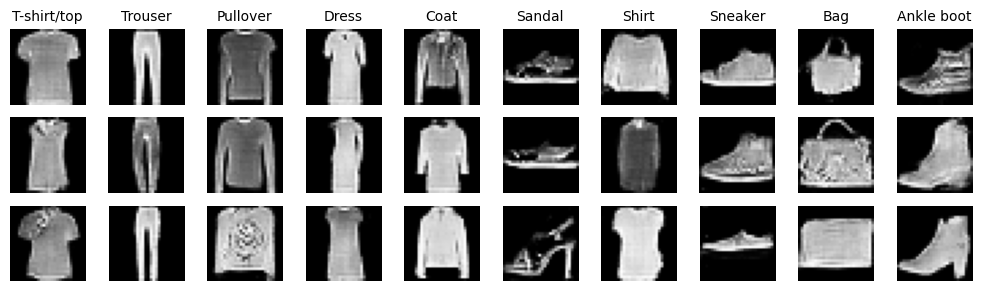

Epoch [11/30]  D_loss: 1.0483  G_loss: 1.6975  LR_G: 0.000100  LR_D: 0.000100
Epoch [12/30]  D_loss: 0.8879  G_loss: 1.5194  LR_G: 0.000100  LR_D: 0.000100
Epoch [13/30]  D_loss: 0.8904  G_loss: 1.9528  LR_G: 0.000100  LR_D: 0.000100
Epoch [14/30]  D_loss: 0.8636  G_loss: 2.0429  LR_G: 0.000100  LR_D: 0.000100
Epoch [15/30]  D_loss: 0.9097  G_loss: 1.6631  LR_G: 0.000100  LR_D: 0.000100
Epoch [16/30]  D_loss: 0.9087  G_loss: 2.2551  LR_G: 0.000100  LR_D: 0.000100
Epoch [17/30]  D_loss: 0.7753  G_loss: 2.2027  LR_G: 0.000100  LR_D: 0.000100
Epoch [18/30]  D_loss: 0.7860  G_loss: 2.2760  LR_G: 0.000100  LR_D: 0.000100
Epoch [19/30]  D_loss: 0.9551  G_loss: 1.8938  LR_G: 0.000100  LR_D: 0.000100
Epoch [20/30]  D_loss: 0.7418  G_loss: 1.6746  LR_G: 0.000050  LR_D: 0.000050


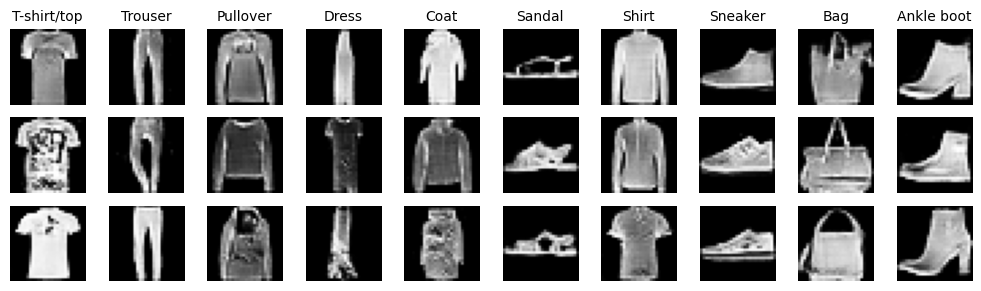

Epoch [21/30]  D_loss: 0.6638  G_loss: 2.0650  LR_G: 0.000050  LR_D: 0.000050
Epoch [22/30]  D_loss: 0.5899  G_loss: 2.1948  LR_G: 0.000050  LR_D: 0.000050
Epoch [23/30]  D_loss: 0.7861  G_loss: 1.8848  LR_G: 0.000050  LR_D: 0.000050
Epoch [24/30]  D_loss: 0.9509  G_loss: 1.9680  LR_G: 0.000050  LR_D: 0.000050
Epoch [25/30]  D_loss: 0.5085  G_loss: 2.1429  LR_G: 0.000050  LR_D: 0.000050
Epoch [26/30]  D_loss: 0.9569  G_loss: 2.1575  LR_G: 0.000050  LR_D: 0.000050
Epoch [27/30]  D_loss: 0.6002  G_loss: 2.2122  LR_G: 0.000050  LR_D: 0.000050
Epoch [28/30]  D_loss: 0.6220  G_loss: 2.3701  LR_G: 0.000050  LR_D: 0.000050
Epoch [29/30]  D_loss: 0.9647  G_loss: 2.0628  LR_G: 0.000050  LR_D: 0.000050
Epoch [30/30]  D_loss: 0.5238  G_loss: 2.5993  LR_G: 0.000025  LR_D: 0.000025


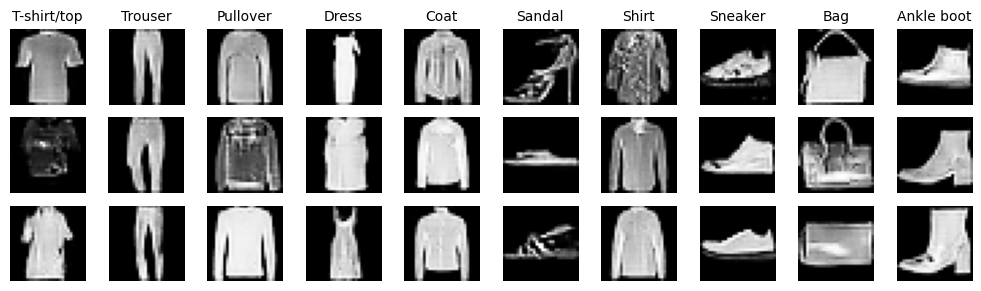

In [ ]:
# 모델 초기화
# GAN의 생성자와 판별자 네트워크 인스턴스 생성 및 디바이스로 이동
generator2 = ResNetGenerator().to(device)
discriminator2 = ResNetDiscriminator().to(device)

# epochs = 30
criterion2 = nn.BCELoss()
optimizer_G2 = optim.Adam(generator2.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D2 = optim.Adam(discriminator2.parameters(), lr=0.0002, betas=(0.5, 0.999))
# StepLR 스케줄러 정의: 10 에포크마다 lr 0.5배 감소
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G2, step_size=10, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D2, step_size=10, gamma=0.5)
for epoch in range(epochs):
    # 배치 단위 데이터 로딩과 준비
    for i, (imgs, labels) in enumerate(train_loader):#train_loader에서 배치 단위로 이미지를 읽음
        # 실제 배치 크기(batch_size_current)를 구함 (마지막 배치는 작을 수 있음)
        batch_size_current = imgs.size(0)

        # 이미지 및 레이블을 GPU/CPU 장치로 이동
        imgs = imgs.to(device)
        labels = labels.to(device)

        # 실제 이미지에 대한 진짜 레이블(1)과 가짜 이미지에 대한 가짜 레이블(0) 생성
        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D2.zero_grad()# 기울기 초기화

        # 실제 이미지 + 레이블 입력, 판별자가 진짜라고 판단하는 손실 계산 (real_loss)
        real_loss = criterion2(discriminator2(imgs, labels), valid)

        # 생성자에서 노이즈+레이블로 가짜 이미지 생성
        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels
        gen_imgs = generator2(noise, gen_labels)

        # 가짜 이미지 + 레이블 입력, 판별자가 가짜로 판단하는 손실 (fake_loss)
        fake_loss = criterion(discriminator2(gen_imgs.detach(), labels), fake)

        # 총 판별자 손실: 진짜-가짜 손실 합산 (d_loss)
        d_loss = real_loss + fake_loss

        # 역전파(backward()) 후 판별자 파라미터 갱신
        d_loss.backward()

        # 참고: gen_imgs.detach()는 생성자 그래프와 분리하여 판별자 학습 시 생성자 네트워크가 업데이트되지 않게 함.
        optimizer_D2.step()


        # 생성자 학습
        optimizer_G2.zero_grad()# 기울기 초기화
        # 판별자의 출력값이 진짜(1)에 가깝도록 생성자가 속이는 정도를 손실로 계산
        g_loss = criterion(discriminator2(gen_imgs, labels), valid)

        # 역전파로 생성자 파라미터 업데이트 (판별자의 판단을 속이는 방향으로)
        g_loss.backward()
        optimizer_G2.step()
    scheduler_G.step()
    scheduler_D.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}  LR_G: {scheduler_G.get_last_lr()[0]:.6f}  LR_D: {scheduler_D.get_last_lr()[0]:.6f}")
    # print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        # 생성자를 평가 모드(eval())로 변경 (배치 정규화 등 학습 모드 비활성화)
        generator2.eval()
        # 10 클래스별로 3개씩 생성 (총 30개 이미지)
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples = n_row * n_col

        # 노이즈와 클래스 레이블 벡터 생성하여 이미지 생성
        noise = torch.randn(total_samples, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        gen_imgs = generator2(noise, labels_sample).detach().cpu()

        # 이미지들을 그리드 형태로 출력 (각 열은 각 클래스 이름 타이틀 표시)
        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                if i == 0:
                    axs[i, j].set_title(idx_to_class[j], fontsize=10)
        plt.tight_layout()
        plt.show()
        # 시각화 후 다시 학습 모드(train())로 전환
        generator2.train()

# 평가

In [ ]:
!pip install pytorch-fid

In [ ]:
import os
import shutil
from pytorch_fid import fid_score

# 폴더 초기화 (각 모델별 저장 폴더 따로 만들기)
model1_real_dir = './real_images_model1'
model1_fake_dir = './fake_images_model1'
model2_real_dir = './real_images_model2'
model2_fake_dir = './fake_images_model2'

# 폴더 생성 또는 삭제 후 재생성
for dir_path in [model1_real_dir, model1_fake_dir, model2_real_dir, model2_fake_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# (생성자 모델들에 따라 각각의 생성기에서 가짜 이미지 생성 후 save_image)

# 예: 모델1(앞서 정의된 generator)
generator.eval()
n_samples = 1000
for i in range(n_samples):
    # 특정 클래스에 대한 노이즈 및 레이블 생성
    noise = torch.randn(1, latent_dim, device=device)
    label = torch.randint(0, num_classes, (1,), device=device)
    with torch.no_grad():
        # 이미지 생성
        gen_img = generator(noise, label).cpu()
        img = (gen_img[0]+1)/2.0  # [-1,1] -> [0,1]
        save_image(img, os.path.join(model1_fake_dir, f'model1_{i}.png'))

# 예: 모델2 (generator2)
generator2.eval()
for i in range(n_samples):
    noise = torch.randn(1, latent_dim, device=device)
    label = torch.randint(0, num_classes, (1,), device=device)
    with torch.no_grad():
        gen_img = generator2(noise, label).cpu()
        img = (gen_img[0]+1)/2.0
        save_image(img, os.path.join(model2_fake_dir, f'model2_{i}.png'))

# FID 계산
fid_score_model1 = fid_score.calculate_fid_given_paths(
    [ './real_images', model1_fake_dir ],
    batch_size=64,
    device=device,
    dims=2048
)

fid_score_model2 = fid_score.calculate_fid_given_paths(
    [ './real_images', model2_fake_dir ],
    batch_size=64,
    device=device,
    dims=2048
)

print(f"Model1 FID Score: {fid_score_model1:.4f}")
print(f"Model2 FID Score: {fid_score_model2:.4f}")


100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Model1 FID Score: 42.9816
Model2 FID Score: 28.8750


FID(Fréchet Inception Distance) 점수- 낮을수록 모델이 생성한 이미지가 실제 이미지 분포에 더 가깝고 품질이 좋다고 해석

FID 점수(FID는 생성 이미지와 실제 이미지 간의 통계적 거리를 수치화한 지표)
- 0에 가까울수록 생성 이미지가 실제 이미지를 매우 잘 모방한 것이며, 점수가 높을수록 차이가 큽니다.
- 일반적으로 GAN 등의 생성 모델 성능을 평가할 때 널리 사용되며, 한 모델이 다른 모델보다 FID가 낮으면 더 우수한 성능을 의미합니다.

결과 해석: Model2가 모델1보다 상대적으로 더 품질 좋은 이미지를 생성했다
